In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv


<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">
    <h2>Project Scope</h2>
        <ul>
            <li>Using solar generation and associated temperature data to explore time series forecasting.</li>
            <li>Compare the performance of ML models and a deep learning LSTM model to make a day-ahead forecast of power generation</li>
            <li>See what impact including the temperature data has on the forecast</li>
            <li>Experiment with feature engineering and test the impact differernt features have on the models</li>
            <li>Fine tune the models</li>
            <li>Report on what model is ultimately more successful and comment on possible project extensions</li>
    </ul>
</span>

<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">
    <h2>Loading and exploring data</h2>
This data was taken from two solar plants in India over the course of 34 days in 15 minute intervals. The weather data is on the plant level (just measured from one sensor) and the generation data is gathered from individual inverters across the plant. More information can be found here: 
<a href="https://www.kaggle.com/datasets/anikannal/solar-power-generation-data">Data Card</a>. Credit to 
<a href="https://www.kaggle.com/anikannal">Ani Kannal</a> for uploading this dataset to Kaggle.
</span>

In [2]:
df_plt1_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
df_plt2_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv')
df_plt1_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
df_plt2_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

df_plt1_gen.sample(10)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
16412,23-05-2020 15:30,4135001,adLQvlD726eNBSB,8927.428571,873.400000,7671.285714,6336622.286
39448,04-06-2020 00:15,4135001,zBIq5rxdHJRwDNY,0.000000,0.000000,0.000000,6484342.000
49972,09-06-2020 01:45,4135001,McdE0feGgRqW7Ca,0.000000,0.000000,0.000000,7346782.000
50558,09-06-2020 08:15,4135001,wCURE6d3bPkepu2,6093.000000,597.000000,500.875000,6968470.875
49564,08-06-2020 21:00,4135001,pkci93gMrogZuBj,0.000000,0.000000,8344.000000,7354476.000
44807,06-06-2020 14:15,4135001,rGa61gmuvPhdLxV,12559.571430,1225.014286,5425.285714,7278515.286
38423,03-06-2020 12:30,4135001,bvBOhCH3iADSZry,10598.875000,1035.587500,3485.250000,6448972.250
49071,08-06-2020 15:30,4135001,VHMLBKoKgIrUVDU,6529.428571,639.228571,7490.000000,7393698.000
4082,17-05-2020 02:00,4135001,wCURE6d3bPkepu2,0.000000,0.000000,0.000000,6795470.000
55442,11-06-2020 15:45,4135001,wCURE6d3bPkepu2,6244.000000,611.714286,4993.285714,6987396.286


<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">PLANT_ID is the same throughout, so it can be safely removed. The generation is 0 for nighttime, which of course makes sense for solar power.</span>

In [3]:
df_plt1_gen = df_plt1_gen.drop('PLANT_ID', axis=1)
df_plt1_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   SOURCE_KEY   68778 non-null  object 
 2   DC_POWER     68778 non-null  float64
 3   AC_POWER     68778 non-null  float64
 4   DAILY_YIELD  68778 non-null  float64
 5   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), object(2)
memory usage: 3.1+ MB


<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">The dtypes make sense, but we'll need to make the DATE_TIME a datetime object for easier analysis. No nulls detected here, but there still could be outliers or nulls encoded in a different way.</span>

In [4]:
df_plt1_gen['DATE_TIME'] = pd.to_datetime(df_plt1_gen.DATE_TIME, format='%d-%m-%Y %H:%M')
df_plt1_gen.dtypes

DATE_TIME      datetime64[ns]
SOURCE_KEY             object
DC_POWER              float64
AC_POWER              float64
DAILY_YIELD           float64
TOTAL_YIELD           float64
dtype: object

<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">Now we can make some additional features out of the datetime object to aid in our analysis. If we were modeling throughout the year(s), month and year could be interesting to account for seasonal variation and long-term trends, but since our data only covers 34 days, we will omit them. We can use dayofyear to capture any longer trends that might be present.</span>

In [5]:
df_plt1_gen['HOUR'] = df_plt1_gen.DATE_TIME.dt.hour
df_plt1_gen['DAY'] = df_plt1_gen.DATE_TIME.dt.dayofyear
df_plt1_gen['MINUTES'] = df_plt1_gen.DATE_TIME.dt.time
#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df_plt1_gen['MINUTES'] = df_plt1_gen.MINUTES.map({df_plt1_gen.MINUTES.unique()[i-1]:i for i in range(1, 97)})

<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">Next, let's check on the linear correlation of features using a heat map</span>

In [6]:
corr = df_plt1_gen.corr(numeric_only=True)
corr

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,HOUR,DAY,MINUTES
DC_POWER,1.000000,0.999996,0.082284,0.003815,0.024104,-0.030539,0.024131
AC_POWER,0.999996,1.000000,0.082234,0.003804,0.024101,-0.030471,0.024127
DAILY_YIELD,0.082284,0.082234,1.000000,0.009867,0.836124,-0.003013,0.836208
TOTAL_YIELD,0.003815,0.003804,0.009867,1.000000,0.004988,0.172868,0.004991
HOUR,0.024104,0.024101,0.836124,0.004988,1.000000,-0.008660,0.999171
DAY,-0.030539,-0.030471,-0.003013,0.172868,-0.008660,1.000000,-0.008634
MINUTES,0.024131,0.024127,0.836208,0.004991,0.999171,-0.008634,1.000000


<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">And why not make it a heatmap</span>

<Axes: >

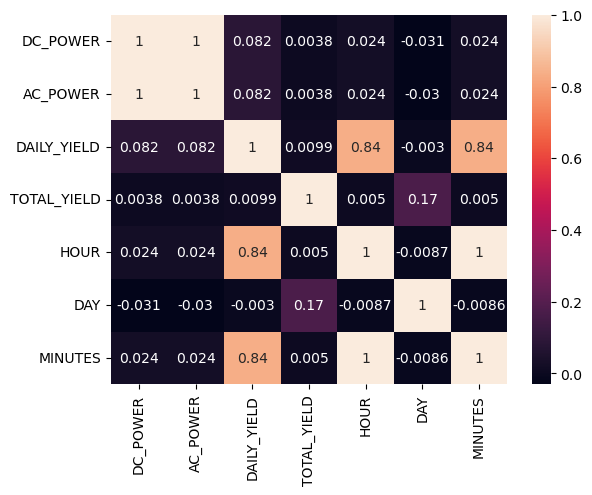

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Spectral')

sns.heatmap(corr, annot=True)

<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">Not surprisingly DC and AC power are highly correlated. This is good! It probably means the inverters in the plant are working correctly to convert the DC to AC. We will ultimately make AC_POWER our target and are probably safe to remove DC_POWER at this point. There is a strong correlation between HOUR and DAILY_YIELD, which makes sense as the daily yield increases throughout the day. Now we will look at a pairplot to see another representation of these relationships and look for any non-linear correlations.</span>

In [8]:
df_plt1_gen = df_plt1_gen.drop('DC_POWER', axis=1)

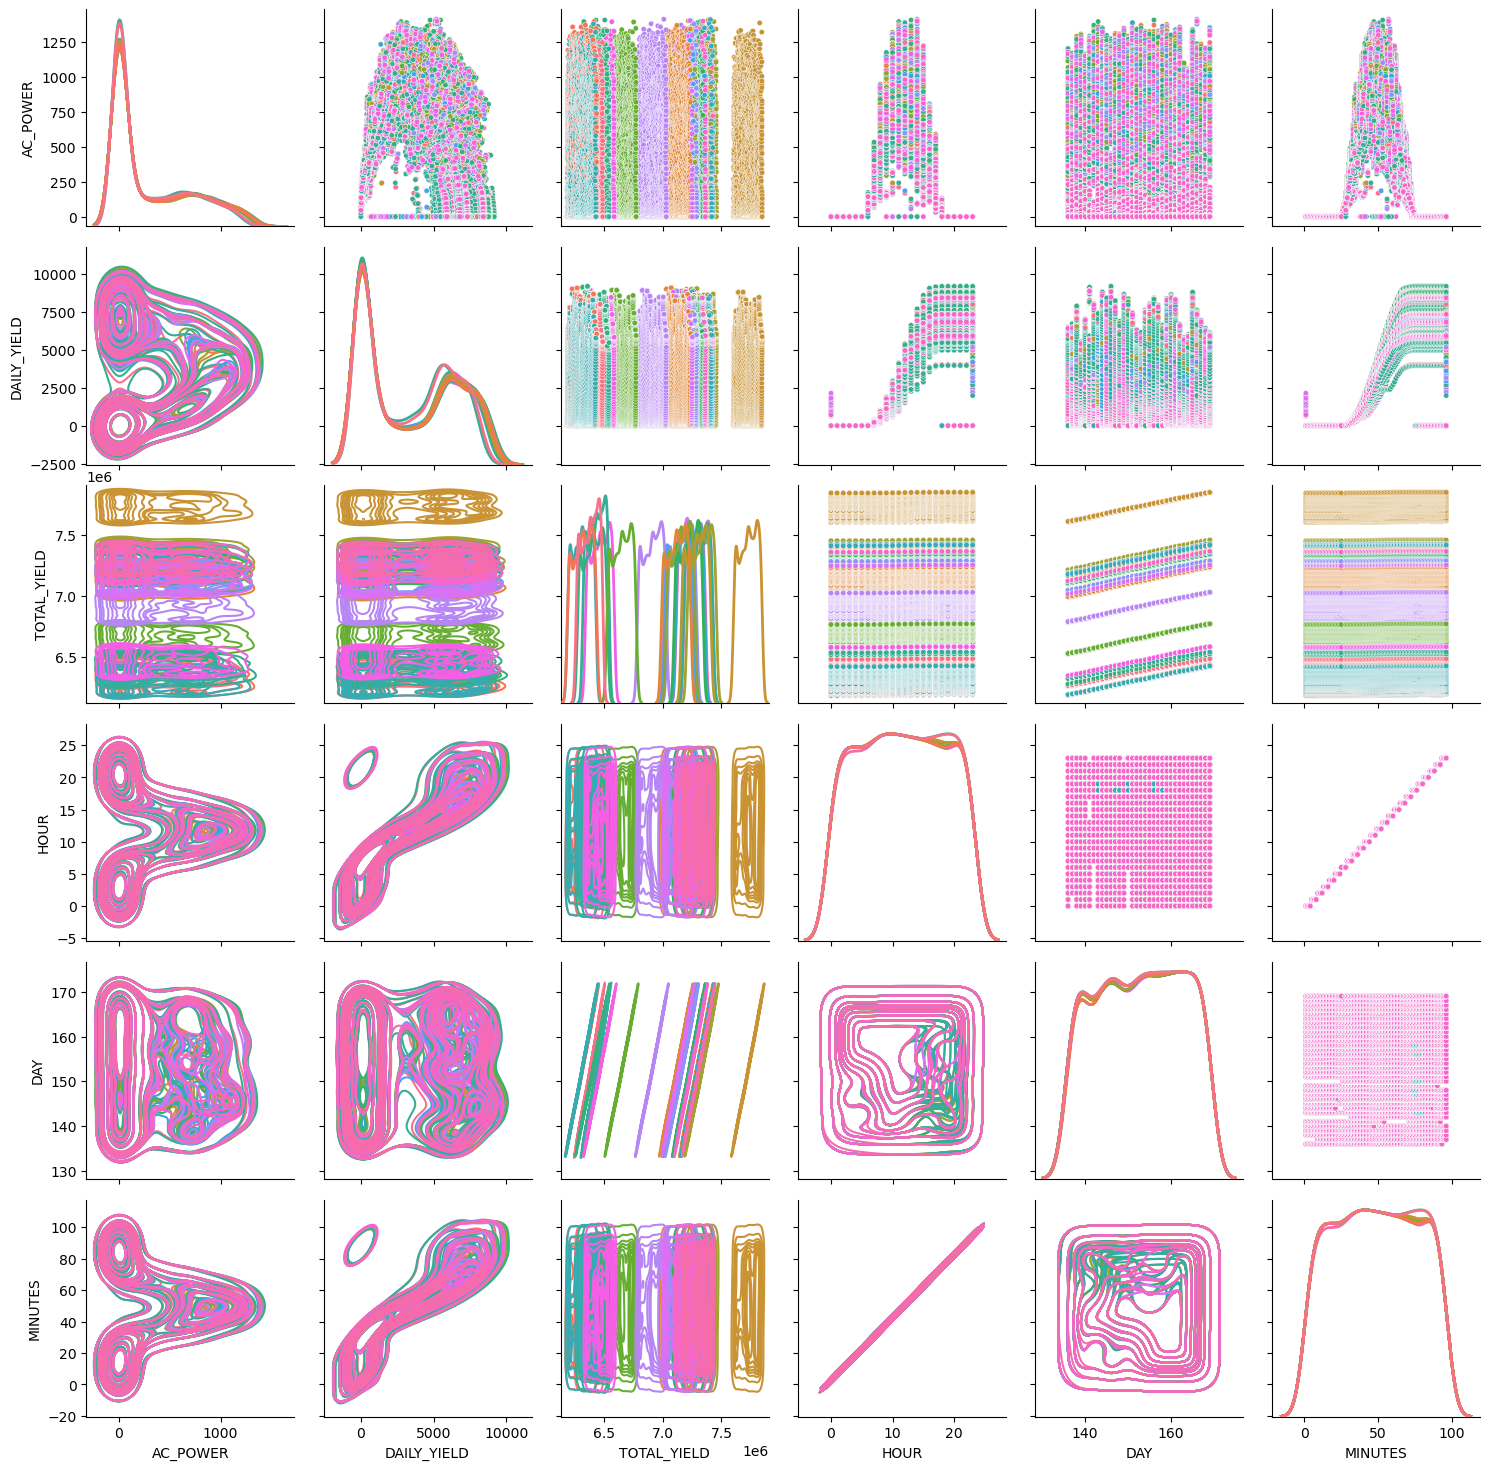

In [9]:
# sns.pairplot(df_plt1_gen, diag_sharey=False, hue='SOURCE_KEY')
g = sns.PairGrid(df_plt1_gen, diag_sharey=False, hue='SOURCE_KEY')
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">The zeros dominate the distribution for AC_POWER and DAILY_YIELD due to the nighttime. It looks like some data is missing based on the DAY/MINUTES pair. We can look at this later. The connection between HOUR and AC_POWER is interesting and also makes sense with the peaks in the middle of the day. Let's explore that more next and also start to look for outliers.</span>

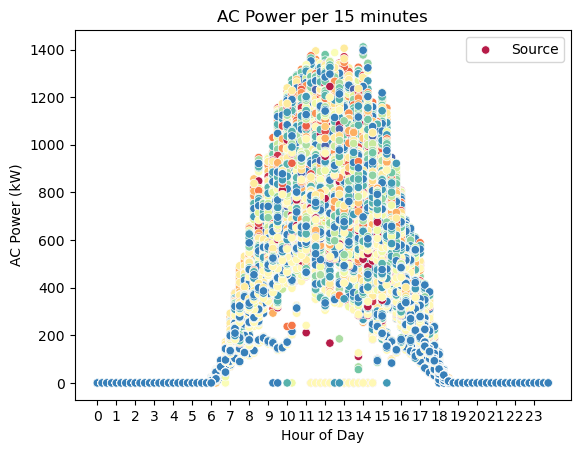

In [10]:
fig, ax = plt.subplots()
sns.color_palette("Paired")
sns.scatterplot(data=df_plt1_gen, y='AC_POWER', x='MINUTES', hue='SOURCE_KEY', palette='Spectral', legend=False)
plt.title('AC Power per 15 minutes')
plt.ylabel('AC Power (kW)')
plt.xlabel('Hour of Day')
ax.set_xticks([i for i in range(1, 97, 4)])
ax.set_xticklabels([i for i in range(24)])
ax.legend(['Source'])

<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">The inverters 